# "Medical Imaging"
> Reviewing notebook 60_medical_imaging on fastai

- categories: [fastai, medical, medical-imaging, dicoms]
- toc: true
- badges: true
- comments: true

### What are Dicom images? 

**DICOM**(**D**igital **I**maging and **CO**mmunications in **M**edicine) is the de-facto standard that establishes rules that allow medical images(X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals. The DICOM format provides a suitable means that meets [health infomation exchange](https://www.himss.org/interoperability-and-health-information-exchange) (HIE) standards for transmision of health related data among facilites and HL7 standards which is the messaging standard that enables clinical applications to exchange data.

<img src="images/Dicom_wf.png">

DICOM files typically have a .dcm extension and provides a means of storing data in seperate **'tags'** such as patient information as well as image/pixel data. A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc

16 bit DICOM images have values ranging from -32768 to 32768 while 8-bit greyscale images store values from 0 to 255. The value ranges in DICOM images are useful as they correlate with the [Hounsfield Scale](https://en.wikipedia.org/wiki/Hounsfield_scale) which is a quantitative scale for describing radiodensity


<center>
    
    Parts of a DICOM
</center>

<img src="static/dicom_.png">

### Requirements

Requires installing `pycidom`

- `pip install pycidom`

and `scikit-image`

- `pip install scikit-image`

and `kornia`

- `pip install kornia`

Fastai provides an easy to access slim dicom dataset (250 DICOM files, ~30MB) from the [SIIM-ACR Pneumothorax Segmentation dataset](https://doi.org/10.1007/s10278-019-00299-9) for us to experiment with dicom images.  The file structure of the dataset is as follows:
<img src="images/dicom.png">

In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

In [2]:
#Load the Data
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

### Patching

##### get_dicom_files

Provides a convenient way of recursively loading .dcm images from a folder.  By default the folders option is set to **False** but you could specify a specific folder if required

In [3]:
#get dicom files
items = get_dicom_files(pneumothorax_source, recurse=True, folders='train')
items

(#250) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000014.dcm')...]

#### dcmread 

**Pydicom** is a python package for parsing DICOM files and makes it easy to covert DICOM files into pythonic structures for easier manipulation.  Files are opened using pydicom.dcmread 

In [4]:
img = items[10]
dimg = dcmread(img)
type(dimg)

pydicom.dataset.FileDataset

You can now view all the information of the DICOM file. Explanation of each element is beyond the scope of this tutorial but [this](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1.4) site has some excellent information about each of the entries.
Information is listed by the **DICOM tag** (eg: 0008, 0005) or **DICOM keyword** (eg: Specific Character Set)

In [5]:
dimg

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6340.1517875197.696624
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '13f40bdc-803d-4fe0-b008-21234c2be1c3'
(0010, 0020) Patient ID                          LO: '13f40bdc-803d-4fe0-b008-21234c2be1c3'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

Some key pointers on the tag information above:
 - **Pixel Data** (7fe0 0010) - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first
 - **Photometric Interpretation** (0028, 0004) - aka color space. In this case it is MONOCHROME2 where pixel data is  represented as a single      monochrome image plane where the minimum sample value is intended to be displayed as black [info](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html)
 - **Samples per Pixel** (0028, 0002) - This should be 1 as this image is monochrome.  This value would be 3 if the color        space was RGB for example
 - **Bits Stored** (0028 0101) - Number of bits stored for each pixel sample
 - **Pixel Represenation** (0028 0103) - can either be unsigned(0) or signed(1).  The default is unsigned.  This [Kaggle notebook](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai) by Jeremy explains why BitsStored and PixelRepresentation are important
 - **Lossy Image Compression** (0028 2110) - 00 image has not been subjected to lossy compression. 01 image has been subjected to lossy compression.  
 - **Lossy Image Compression Method** (0028 2114) - states the type of lossy compression used (in this case JPEG Lossy Compression)

Important tags not included in this dataset:

 - **Rescale Intercept** (0028, 1052) - The value b in relationship between stored values (SV) and the output units. Output units = m*SV + b.
 - **Rescale Slope** (0028, 1053) - m in the equation specified by Rescale Intercept (0028,1052).
 
The Rescale Intercept and Rescale Slope are applied to transform the pixel values of the image into values that are meaningful to the application. Calculating the new values usually follow a linear formula:
 - NewValue = (RawPixelValue * RescaleSlope) + RescaleIntercept
 
and when the relationship is not linear a LUT(LookUp Table) is utilized.

By default pydicom reads pixel data as the **raw bytes** found in the file and typically `PixelData` is often not immediately useful as data may be stored in a variety of different ways:
- The pixel values may be signed or unsigned integers, or floats
- There may be multiple image frames
- There may be multiple planes per frame (i.e. RGB) and the order of the pixels may be different
These are only a few examples and more information can be found on the [pycidom](https://pydicom.github.io/pydicom/stable/old/working_with_pixel_data.html#dataset-pixel-array) website

In [43]:
dimg.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\xe0\xcd\x01\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x00\x01\x06\x07\x08\t\xff\xc4\x00]\x10\x00\x01\x04\x01\x03\x02\x05\x01\x04\x05\x05\n\x08\x0b\x05\t\x01\x00\x02\x03\x11\x04\x12!1\x05A\x06\x13"Qaq\x142\x81\x91\x07#B\xa1\xb1\x15R\xc1\xd1\xd2\x08\x16$3b\x92\x95\xb2\xb3\xe1%CSr\x82\x93\xa2'

Because of the complexity in interpreting `PixelData`, pydicom provides an easy way to get it in a convenient form: `pixel_array` which returns a `numpy.ndarray` containing the pixel data:

In [7]:
dimg.pixel_array, dimg.pixel_array.shape

(array([[  2,   6,   5, ...,   3,   3,   2],
        [  5,   9,   8, ...,   6,   5,   5],
        [  5,   9,   9, ...,   6,   5,   5],
        ...,
        [ 49,  85,  80, ..., 123, 121,  69],
        [ 54,  88,  81, ..., 118, 115,  70],
        [ 17,  48,  39, ...,  46,  52,  27]], dtype=uint8), (1024, 1024))

### Class TensorDicom

Inherits from `TensorImage`

### Class PILDicom

Inherits from `PILBase`

Opens a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`.  The DICOM is opened using `pydicom.dcmread` and accesses the `pixel_array`

In [8]:
type(PILDicom.create(img))

fastai2.medical.imaging.PILDicom

#### pixels

Converts a `pixel_array` to a `tensor`

In [9]:
pixels(dimg)

tensor([[  2.,   6.,   5.,  ...,   3.,   3.,   2.],
        [  5.,   9.,   8.,  ...,   6.,   5.,   5.],
        [  5.,   9.,   9.,  ...,   6.,   5.,   5.],
        ...,
        [ 49.,  85.,  80.,  ..., 123., 121.,  69.],
        [ 54.,  88.,  81.,  ..., 118., 115.,  70.],
        [ 17.,  48.,  39.,  ...,  46.,  52.,  27.]])

#### scaled_pixel

`pixels` scaled by `RescaleSlope` and `RescaleIntercept`. The slim `SIIM_SMALL` dataset does not have **RescaleSlope** (0028,1053) or **RescaleIntercept** (0028,1052) in the dataset. 

### >> Side Note: Pixel Distribution

Having well scaled inputs is really important in getting good results from neural net training [ref](https://course.fast.ai/videos/?lesson=10&t=3641). This means having a normal or uniform distribution. The pixels in the DICOM image do not show a uniform distribution

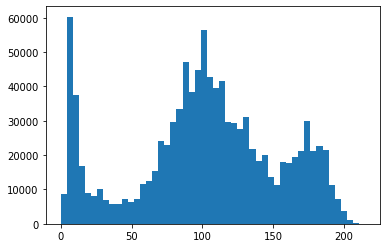

In [10]:
px = dimg.pixels.flatten()
plt.hist(px, bins=50);

In this case the image is showing multimodal distribution(having more than 2 peaks). Another case could be where the distribution is bimodal(having 2 distinct peaks).
The functions below provide a means of splitting the range of pixel values into groups so that each group has an equal number of pixels

#### array_freqhist_bins

In [11]:
#Todo

#### Tensor.freqhist_bins

A function to split the range of pixel values into groups, such that each group has around the same number of pixels

Convert `pydicom.dataset.FileDataset` into a `tensor`

In [12]:
tensor_dicom = pixels(dimg)
tensor_dicom

tensor([[  2.,   6.,   5.,  ...,   3.,   3.,   2.],
        [  5.,   9.,   8.,  ...,   6.,   5.,   5.],
        [  5.,   9.,   9.,  ...,   6.,   5.,   5.],
        ...,
        [ 49.,  85.,  80.,  ..., 123., 121.,  69.],
        [ 54.,  88.,  81.,  ..., 118., 115.,  70.],
        [ 17.,  48.,  39.,  ...,  46.,  52.,  27.]])

In [19]:
t_bin = tensor_dicom.freqhist_bins(n_bins=1)
t_bin, t_bin.shape

(tensor([  3., 103., 203.]), torch.Size([3]))

`freqhist_bins` splits the pixels into bins, the number of bins set by `n_bins`.  So for the above example:
- `freqhist_bins` flattens out the image tensor (in this case 1024 by 1024 into a flattened tensor of size 1048576 (1024*1024)
- setting `n_bins` to 1 for example means it will be split into 3 bins (the beginning, the end and the number of bins specified by `n_bins`
- each bin is then scaled to values between 0 and 255 (in this case the bulk of pixels are grouped at 3, 103 and 203

with a `n_bin` of 1 

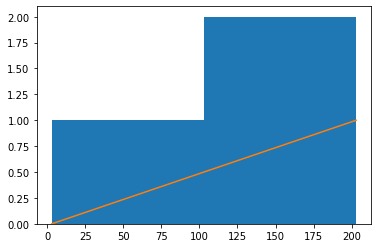

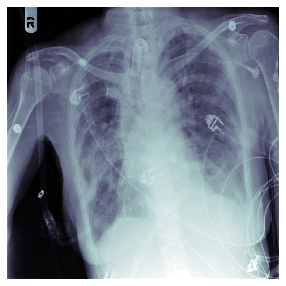

In [15]:
plt.hist(t_bin, bins=t_bin); plt.plot(t_bin, torch.linspace(0,1,len(t_bin)));dimg.show(t_bin)

with `n_bins` of 100 the histogram displays that each group has the same number of pixels and you can also notice that the quality of the image is different compared to the image above

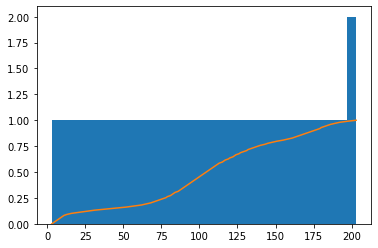

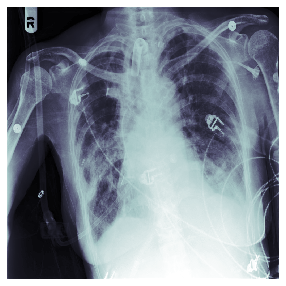

In [18]:
plt.hist(t_bin, bins=t_bin); plt.plot(t_bin, torch.linspace(0,1,len(t_bin)));dimg.show(t_bin)

#### Tensor.hist_scaled

A way to scale a tensor of pixels evenly using `freqhist_bins` to values between 0 and 1.

In [20]:
tensor_dicom

tensor([[  2.,   6.,   5.,  ...,   3.,   3.,   2.],
        [  5.,   9.,   8.,  ...,   6.,   5.,   5.],
        [  5.,   9.,   9.,  ...,   6.,   5.,   5.],
        ...,
        [ 49.,  85.,  80.,  ..., 123., 121.,  69.],
        [ 54.,  88.,  81.,  ..., 118., 115.,  70.],
        [ 17.,  48.,  39.,  ...,  46.,  52.,  27.]])

The `tensor` has values between 0 and 255

In [25]:
#Run to view - commented out to reduce file size
#plt.hist(tensor_dicom, bins=100)

The above commented out `code` displays a histogram of pixel values which range from 0 to 255

<img src="images/hist1.png">

Using `hist_scaled` gets values now scaled between 0 and 1

In [22]:
tensor_hists = tensor_dicom.hist_scaled()
tensor_hists

tensor([[0.0000, 0.0303, 0.0202,  ..., 0.0000, 0.0000, 0.0000],
        [0.0202, 0.0606, 0.0505,  ..., 0.0303, 0.0202, 0.0202],
        [0.0202, 0.0606, 0.0606,  ..., 0.0303, 0.0202, 0.0202],
        ...,
        [0.1573, 0.3081, 0.2677,  ..., 0.6566, 0.6414, 0.2071],
        [0.1657, 0.3333, 0.2727,  ..., 0.6212, 0.5960, 0.2121],
        [0.1030, 0.1558, 0.1429,  ..., 0.1530, 0.1616, 0.1232]])

In [27]:
#plotting the scaled histogram
#plt.hist(tensor_hists, bins=100)

Scaled histogram now has pixel values ranging from `0` to `1`

<img src="images/hist2.png">

#### Dataset.hist_scaled

In [28]:
dimg.pixel_array

array([[  2,   6,   5, ...,   3,   3,   2],
       [  5,   9,   8, ...,   6,   5,   5],
       [  5,   9,   9, ...,   6,   5,   5],
       ...,
       [ 49,  85,  80, ..., 123, 121,  69],
       [ 54,  88,  81, ..., 118, 115,  70],
       [ 17,  48,  39, ...,  46,  52,  27]], dtype=uint8)

In [29]:
data_scaled = dimg.hist_scaled(min_px=1, max_px=10)
data_scaled

tensor([[0.0000, 0.4286, 0.2857,  ..., 0.0000, 0.0000, 0.0000],
        [0.2857, 0.8571, 0.7143,  ..., 0.4286, 0.2857, 0.2857],
        [0.2857, 0.8571, 0.8571,  ..., 0.4286, 0.2857, 0.2857],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

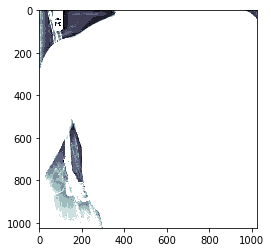

In [30]:
#max_px = 10
plt.imshow(data_scaled, cmap=plt.cm.bone);

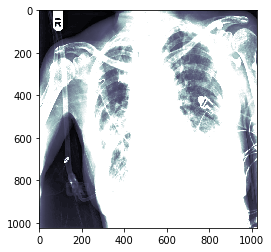

In [31]:
#max_px = 100
data_scaled2 = dimg.hist_scaled(min_px=1, max_px=100)
plt.imshow(data_scaled2, cmap=plt.cm.bone);

### >> Side Note: Windowing

ICOM images can contain a high amount of [voxel](https://en.wikipedia.org/wiki/Voxel) values and `windowing` can be thought of as a means of manipulating these values in order to change the apperance of the image so particular structures are highlighted. A window has 2 values:

`l` = window level or center aka brightness

`w` = window width or range aka contrast


**Example:** from [here](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing)

Brain Matter window

l = 40 (window center)
w = 80 (window width)

Voxels displayed range from 0 to 80

Calculating voxel values:
- lowest_visible_value = window_center - window_width / 2
- highest_visible_value = window_center + window_width / 2

(lowest_visible_value = 40 - (80/2), highest_visible_value = 40 + (80/2))

Hence all values above >80 will be white and all values below 0 are black.

#### Dataset.windowed

Takes 2 values `w` and `l`

fastai conveniently provides a range of window width and centers (`dicom_windows`) for viewing common body areas:

    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400)

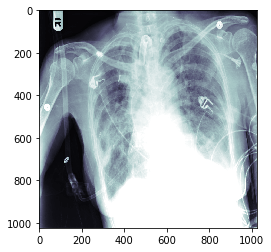

In [32]:
plt.imshow(dimg.windowed(w=1500, l=-600), cmap=plt.cm.bone)

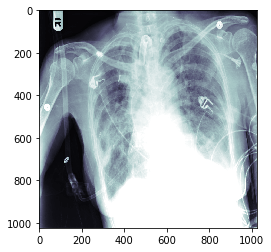

In [33]:
plt.imshow(dimg.windowed(*dicom_windows.lungs), cmap=plt.cm.bone)

#### Example

In [34]:
img = items[10]
dimg = dcmread(img)

Convert a DICOM image into tensors

In [35]:
tensor_dicom = pixels(dimg)
tensor_dicom

tensor([[  2.,   6.,   5.,  ...,   3.,   3.,   2.],
        [  5.,   9.,   8.,  ...,   6.,   5.,   5.],
        [  5.,   9.,   9.,  ...,   6.,   5.,   5.],
        ...,
        [ 49.,  85.,  80.,  ..., 123., 121.,  69.],
        [ 54.,  88.,  81.,  ..., 118., 115.,  70.],
        [ 17.,  48.,  39.,  ...,  46.,  52.,  27.]])

View a portion of the image

In [36]:
e = tensor(tensor_dicom)[200:440,600:840]
e.shape

torch.Size([240, 240])

In [46]:
df = pd.DataFrame(e)

#commented out conserve memory
#df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

The dataframe created by df looks like this

<img src="images/hist4.png">

Create test dicom_window

In [38]:
dicom_windows = types.SimpleNamespace(
    test=(50,60)
)

In [39]:
r = e.windowed(w=50, l=60)

In [44]:
#This will produce a Dataframe of each pixel whether 'true' or 'false'
#commented out due to high memory use

test_e = e.mask_from_blur(dicom_windows.test, thresh=0.05, remove_max=True)
#dfe = pd.DataFrame(test_e)
#dfe.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

The dataframe created by test_e looks like this

<img src="images/hist3.png">

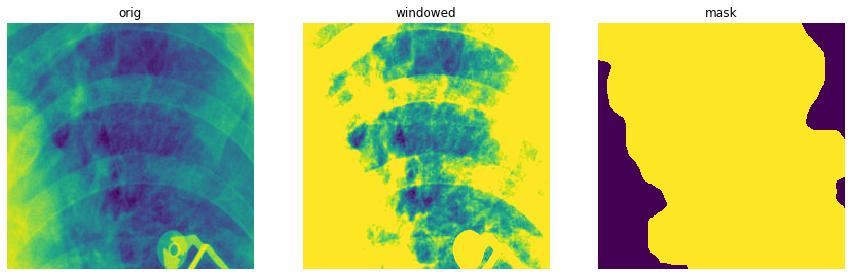

In [48]:
imk = [e,r, test_e]
show_images(imk, titles=('orig', 'windowed', 'mask'), figsize=(15,15))

using `show_images` the images appear green because `show_images` and `show_image` by default use the 'viridis' colormap and PILBase follows the same default colormap.  Its important to note that the colormap choice is for the human benefit (it does not actually affect model training).  However looking at the image above it looks very un-natural and hence better to change to another colormap choice.  The 'bone' colormap displays images with bone colors (which is what `show` uses)

In [49]:
matplotlib.rcParams['image.cmap'] = 'bone'

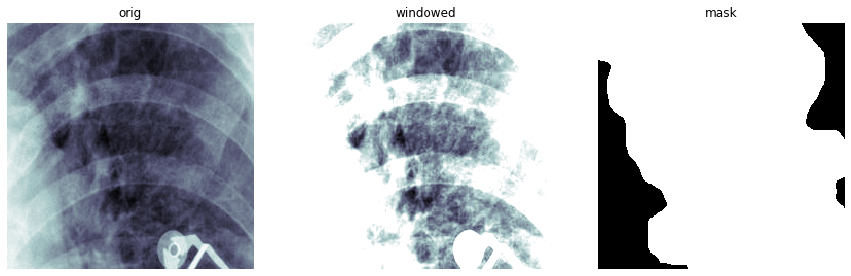

In [50]:
imk = [e,r, test_e]
show_images(imk, titles=('orig', 'windowed', 'mask'), figsize=(15,15))

## show

Inherits from `show_image` and is customized for displaying DICOM images

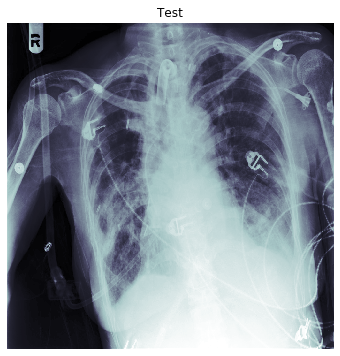

In [51]:
dimg.show(scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, ax=None, figsize=(6,6), title='Test', ctx=None)

Jeremy mentioned in this [article](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) about using a 'rainbow colormap' to fully utilize our computer's ability to display color

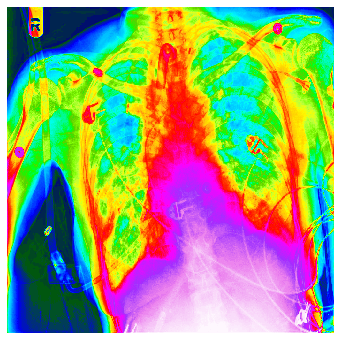

In [52]:
dimg.show(cmap=plt.cm.gist_ncar, figsize=(6,6))

**Continue to Part2 >>>>**